In [237]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 
import json
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
# load NLTK's SnowballStemmer 
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [83]:
def tokenize_and_stem(doc):
    #
    # Remove non-letters or numbers
    text = re.sub(r"[^a-zA-Z]"," ", doc)
    #
    # Convert words to lower case and split them
    words = text.lower().split()
    #
    # Remove stem words
    words = [stemmer.stem(w) for w in words]
    # Return list of words    
    return(words)

In [8]:
path = "raw_data"
with open(path) as f:
    raw_data = [json.loads(line) for line in f]      

In [13]:
job_jds = [d.values()[0] for d in raw_data]
job_ids = [d.values()[1] for d in raw_data]

In [92]:
# Generate tfidf vertorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Set vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=50000, min_df=20, 
                                   stop_words='english', use_idf=True,
                                  tokenizer=tokenize_and_stem, ngram_range=(1,3))

#fit the vectorizer to job description documents
%time tfidf_matrix = tfidf_vectorizer.fit_transform(job_jds) 

print(tfidf_matrix.shape)

Wall time: 1min 54s
(11920, 41626)


In [93]:
terms = tfidf_vectorizer.get_feature_names()

In [152]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [151]:
def top_tfidf_feats(row, features, top_n=10):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [203]:
# Top 10 terms for job 0 
top_feats_in_doc(tfidf_matrix, terms, 0, 10)

,feature,tfidf
0,partner healthcar,0.266216
1,o,0.181311
2,healthcar,0.162689
3,phs,0.138347
4,comfort,0.126949
5,clinic,0.114522
6,hospit,0.106543
7,partner,0.091998
8,organ,0.091509
9,softwar,0.079875


In [204]:
# Top 10 terms for job 50
top_feats_in_doc(tfidf_matrix, terms, 50, 10)

,feature,tfidf
0,bioinformat,0.416051
1,genom,0.218213
2,bioinformat tool,0.212522
3,biolog,0.172088
4,proteom,0.152057
5,gene,0.123809
6,protein,0.120127
7,sequenc,0.110614
8,synthet biolog,0.110052
9,genom sequenc,0.108870


In [95]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(tfidf_matrix)

In [96]:
# K-means clustering
from sklearn.cluster import KMeans

num_clusters = 4

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 12min 6s


In [99]:
# Save results to file
from sklearn.externals import joblib

joblib.dump(km, 'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

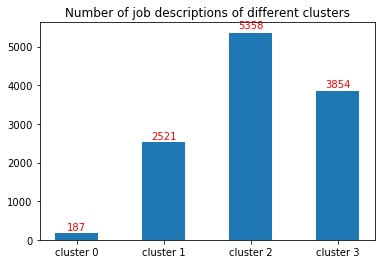

In [236]:
jobs = {'clusters':clusters, 'job_ID':job_ids}
x_axis = range(num_clusters)
x_ticks = [ 'cluster {}'.format(i) for i in x_axis]
y = frame['clusters'].value_counts().sort_index().values
frame = pd.DataFrame(jobs)
fig, ax = plt.subplots()
rects = ax.bar(x_axis,y,width=0.5)
ax.set_xticks(x_axis)
ax.set_xticklabels(x_ticks)

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                '%d' % int(height),
                ha='center', va='bottom', color = 'r')

autolabel(rects)
plt.title("Number of job descriptions for different clusters")
plt.show()

In [202]:
print 'Top 10 terms per cluster:\n'

n_words = 10

ordered_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print "Cluster %d words:" % i
    
    for ind in ordered_centroids[i, :n_words]: 
        print terms[ind]+',',
    print 
    print 

Top terms per cluster:

Cluster 0 words:
goldman, goldman sach, sach, financi, firm, engin, sach group, goldman sach group, client, global,

Cluster 1 words:
research, develop, requir, clinic, test, project, engin, support, manag, s,

Cluster 2 words:
engin, team, learn, product, develop, build, softwar, machin, machin learn, technolog,

Cluster 3 words:
busi, manag, analyt, market, team, report, client, custom, analyst, skill,



In [240]:
path2 = "companies"
with open(path2) as f:
    corps = [json.loads(line) for line in f] 
companies = [d.values()[0] for d in corps]

[u'Partners HealthCare(PHS)',
 u'Houghton Mifflin Harcourt',
 u'Houghton Mifflin Harcourt',
 u'Medtronic',
 u'Raytheon',
 u'Staples',
 u'Wellframe',
 u'ClimaCell',
 u'dataxu',
 u'Liberty Mutual',
 u'Ginkgo Bioworks',
 u'Amazon.com',
 u'athenahealth',
 u'Elemental Machines',
 u'Rocket Software',
 u'UnitedHealth Group',
 u'Raytheon',
 u'Amazon.com',
 u'Freebird']

In [243]:
# Visualize companies clustering

In [111]:
idx = km.cluster_centers_[0].argsort()[::-1]

In [107]:
km.cluster_centers_[0][idx][::-1]

array([ 0.21431015,  0.21321441,  0.21321441, ...,  0.        ,
        0.        ,  0.        ])

In [134]:
tfidf_matrix[0,:]

<1x41626 sparse matrix of type '<type 'numpy.float64'>'
	with 906 stored elements in Compressed Sparse Row format>

In [140]:
type(tfidf_matrix)

scipy.sparse.csr.csr_matrix

In [144]:
np.squeeze(tfidf_matrix[1,:].toarray())

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [143]:
tfidf_matrix[1,:].toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [148]:
x = np.array([[[0],[1],[2]]])
np.squeeze(x, axis=(0,2))

array([0, 1, 2])

In [131]:
idx1=km.cluster_centers_[1].argsort()[::-1]